In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import glob
import librosa as lb
import librosa.display as ldp
import IPython.display as ipd

In [3]:
audio_file = glob.glob('/kaggle/input/gtzan-musicspeech-collection/*/*.wav')

In [9]:
ipd.Audio(audio_files)

In [4]:
y, sr = lb.load(audio_file[34])

In [11]:
y.shape

(661500,)

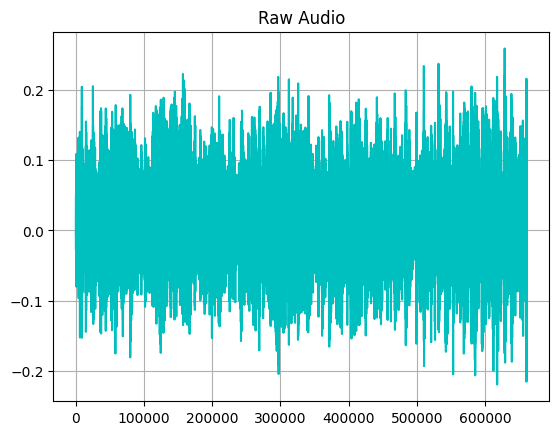

In [12]:
pd.Series(y).plot(title = 'Raw Audio',color = 'c')
plt.grid(True)
plt.show()

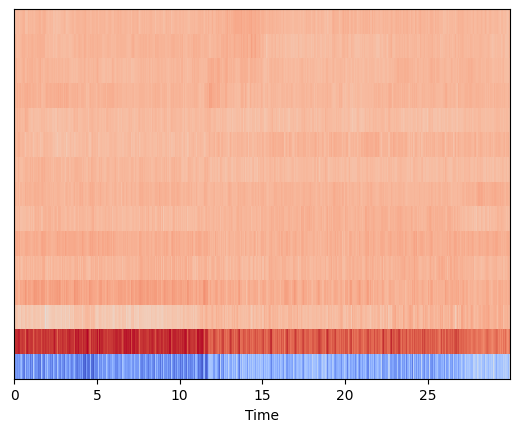

In [5]:
mfcc = lb.feature.mfcc(y=y,sr=sr,n_mfcc=15)
lb.display.specshow(mfcc,x_axis='time',sr=sr,cmap='coolwarm') #or cmap= 'magma'

Extracting and Visualizing MFCC

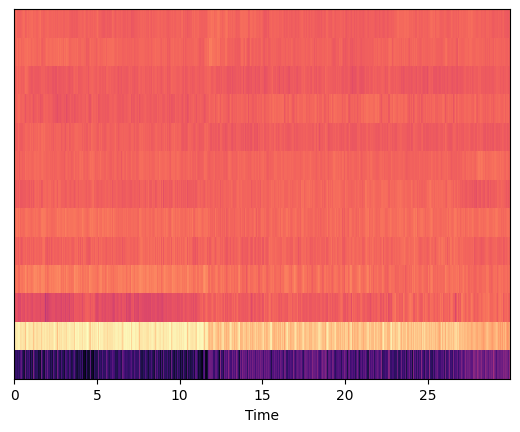

In [16]:
mfcc = lb.feature.mfcc(y=y, sr=sr,n_mfcc=13)

lb.display.specshow(mfcc, x_axis='time', sr=sr,cmap='magma')


In [ ]:
chroma = lb.feature.chroma_stft(y=y, sr=sr)

# Plot
plt.figure(figsize=(12, 5))
lb.display.specshow(chroma, y_axis='chroma', x_axis='time', cmap='coolwarm', sr=sr)
plt.colorbar()
plt.title("Chroma Feature Representation")
plt.tight_layout()
plt.show()

In [ ]:
delta1 = lb.feature.delta(mfcc, order = 2)
lb.display.specshow(delta1,x_axis='time',cmap='coolwarm',sr=sr)

In [ ]:
# Filter out files from the /dataset/ folder
audio_file = [f for f in audio_file if "/dataset/" not in f.lower()]


In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

data = []

for path in tqdm(audio_file):
    label = "speech" if "speech_wav" in path.lower() else "music"
    y, sr = lb.load(path, sr=None)
    #y = y[:sr * 10]  # Trim to 10 seconds
    y = y / np.max(np.abs(y))  # Normalize

    # MFCC
    mfcc = lb.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc_mean = np.mean(mfcc, axis=1)

    # Chroma
    chroma = lb.feature.chroma_stft(y=y, sr=sr)
    chroma_mean = np.mean(chroma, axis=1)

    delta1 = lb.feature.delta(mfcc, order = 2)
    delta_mean = np.mean(delta1, axis=1)

    # Combine features
    features = np.concatenate([mfcc_mean, chroma_mean, delta_mean])
    data.append([path] + features.tolist() + [label])

# Create DataFrame
mfcc_cols = [f"mfcc_{i}" for i in range(13)]
chroma_cols = [f"chroma_{i}" for i in range(12)]
delta_cols = [f"delta_{i}" for i in range(13)]
columns = ["filepath"] + mfcc_cols + chroma_cols + delta_cols + ["label"]

df = pd.DataFrame(data, columns=columns)


In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["filepath", "label"])
y = df["label"]

# Encode labels to numeric
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # speech -> 1, music -> 0 (or vice versa)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)


In [63]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))


In [ ]:
import matplotlib.pyplot as plt

importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 5))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.model_selection import GridSearchCV

grid = {"n_estimators" : [50,100,150,200,250],
       "max_depth": [None, 10, 20],
       "min_samples_split": [2, 5],
       "min_samples_leaf": [1, 2]
}

rfc = RandomForestClassifier()

grid_search = GridSearchCV(
    estimator=rfc,
    param_grid=grid,
    cv=4,  # correct usage
    n_jobs=-1,
    scoring="accuracy",
    verbose=2
)

grid_search.fit(X_train,y_train)

In [ ]:
print("Best Parameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_

#predict
y_pred_b = best_model.predict(X_test)

print('Tuned Accuracy:', accuracy_score(y_pred,y_test))
print("\nClassification Report:", classification_report(y_test,y_pred,target_names=le.classes_))

In [ ]:
import joblib
joblib.dump(best_model, "audio_classifier_rfc.pkl")


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

svm_classifier = SVC(kernel='rbf',C=1.0, gamma = 'scale', random_state = 42)

svm_classifier.fit(X_train_scaled,y_train)

y_pred_svm = svm_classifier.predict(X_test_scaled)

print("SVM Accuracy Score:", accuracy_score(y_test,y_pred_svm))
print("\nSVM Classification Report:",'\n',classification_report(y_test,y_pred_svm,target_names=le.classes_))

In [ ]:
joblib.dump(svm_classifier, "svm_classifier.pkl")

# Feature extraction for deep learning 

In [4]:
import os
import numpy as np
from tqdm import tqdm
import librosa as lb

X = []
y_labels = []

desired_frames = 216  # Set this based on most common shape

for path in tqdm(audio_file):
    label = 1 if "speech_wav" in path.lower() else 0
    y, sr = lb.load(path, sr=None)
    y = y[:sr * 25]  # Trim to 10 sec
    y = y / np.max(np.abs(y))  # Normalize

    y_labels.append(label)

    # Extract features
    mfcc = lb.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    chroma = lb.feature.chroma_stft(y=y, sr=sr)
    delta2 = lb.feature.delta(mfcc, order=2)

    # Make all features the same length
    def fix_length(feature, target_frames):
        if feature.shape[1] < target_frames:
            return np.pad(feature, ((0, 0), (0, target_frames - feature.shape[1])), mode='constant')
        else:
            return feature[:, :target_frames]

    mfcc = fix_length(mfcc, desired_frames)
    chroma = fix_length(chroma, desired_frames)
    delta2 = fix_length(delta2, desired_frames)

    #Concatenate
    combined = np.concatenate([mfcc, chroma, delta2], axis=0)  # shape: (52, 216)
    X.append(combined)

# Convert to NumPy arrays
#X = np.array(X)
#y = np.array(y_labels)
#X = X[..., np.newaxis]  # Now X.shape becomes (128, 52, 216, 1)

#print(X.shape)  # Should be (num_samples, 20, 216, 3)


100%|██████████| 256/256 [00:47<00:00,  5.36it/s]


In [5]:
from sklearn.model_selection import train_test_split

#Splitting the data before and then convert it back to a array for training
X_train, X_test, y_train, y_test = train_test_split(
    X, y_labels, test_size=0.25, random_state=42, stratify=y_labels)


In [6]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_train = X_train[..., np.newaxis]

X_test = np.array(X_test)
y_test = np.array(y_test)
X_test = X_test[..., np.newaxis]

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization


input_shape = (52, 216, 1)

model = Sequential([
    Input(shape=(52, 216, 1)),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    #Dropout(0.4),

    Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    #Dropout(0.3),

    Flatten(),
    #Dense(128, activation='relu'),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binary classification (speech vs music)
])



In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(
    monitor = 'val_loss',
    patience = 5,
    restore_best_weights = False
)

reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.5,
    patience = 3,
    min_lr = 1e-6,
    verbose = 1
)

In [10]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate = 0.0009), loss='binary_crossentropy', metrics=['accuracy'])

from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    callbacks = [early_stop, reduce_lr],
    class_weight=class_weight_dict,
    validation_data=(X_test, y_test)
)


Epoch 1/50


I0000 00:00:1746552023.109985     104 service.cc:148] XLA service 0x78b7a4004ff0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746552023.110701     104 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1746552023.573915     104 cuda_dnn.cc:529] Loaded cuDNN version 90300


11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4546 - loss: 8.5037 

I0000 00:00:1746552027.473584     104 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 118ms/step - accuracy: 0.4616 - loss: 8.0940 - val_accuracy: 0.5156 - val_loss: 2.3387 - learning_rate: 9.0000e-04
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6747 - loss: 1.6851 - val_accuracy: 0.4062 - val_loss: 2.5617 - learning_rate: 9.0000e-04
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7532 - loss: 1.2495 - val_accuracy: 0.4531 - val_loss: 1.8068 - learning_rate: 9.0000e-04
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6026 - loss: 1.2400 - val_accuracy: 0.6250 - val_loss: 0.9801 - learning_rate: 9.0000e-04
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7514 - loss: 0.8925 - val_accuracy: 0.6406 - val_loss: 0.9532 - learning_rate: 9.0000e-04
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7487 - loss: 0.7692 - val_accuracy: 0.6875 - val_loss: 1.0594 - learning_rate: 9.0000e-04
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7798 - loss: 0.7670 -

# Evaluation and Visualization

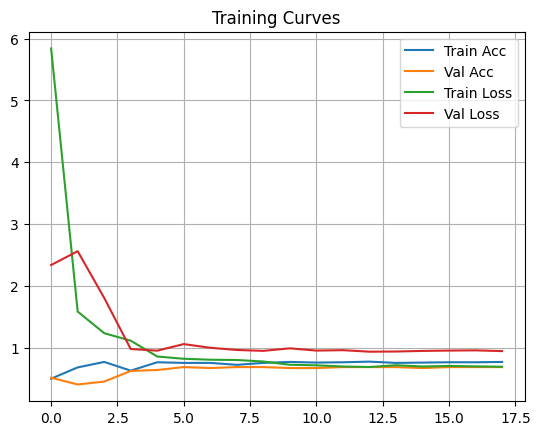

In [11]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.grid(True); plt.title("Training Curves");


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


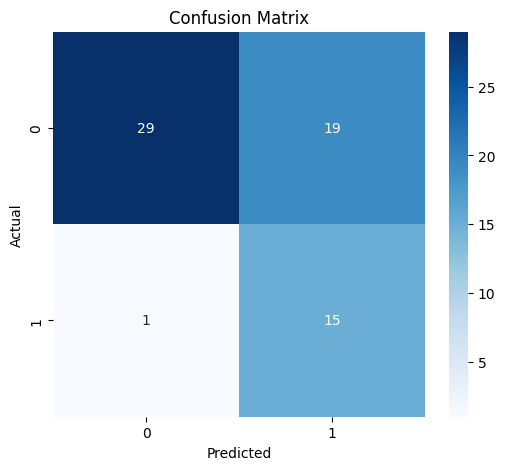

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.60      0.74        48
           1       0.44      0.94      0.60        16

    accuracy                           0.69        64
   macro avg       0.70      0.77      0.67        64
weighted avg       0.84      0.69      0.71        64



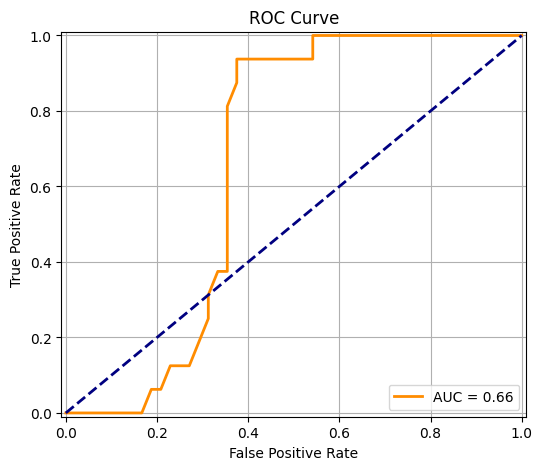

In [89]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get predictions
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.35).astype("int32")  # Threshold at 0.5

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [12]:
import joblib
joblib.dump(model, "audio_classifier_cnn.pkl")


['audio_classifier_cnn.pkl']